In [207]:
import os
import mne
import numpy as np
import warnings
import pyedflib
from tqdm import tqdm
import tensorflow as tf
from mne.io import concatenate_raws
from autoreject import get_rejection_threshold
from mne.decoding import CSP
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mne.set_log_level(verbose=False)

# Control GPU consumption
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "True"

# **Data Preparations**

## Raw Data

In [208]:
def load_data(subject_id:list, task_id:list, montage_name:str):
    dataset_path = "eeg-motor-movementimagery-dataset-1.0.0/files"

    # --- Full Path ---
    filenames = []
    for i in range(len(subject_id)):
        for j in range(len(task_id)):
            filenames.append("S"+subject_id[i]+"/S"+subject_id[i]+"R"+task_id[j]+".edf")
            
    path = [os.path.join(dataset_path, filename).replace("\\", "/") for filename in filenames]

    # --- Read EDF Files ---
    subject_raws = []
    for file_path in path:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        subject_raws.append(data)

    raw_data = concatenate_raws(subject_raws)
    
    with open("eeg-motor-movementimagery-dataset-1.0.0/files/wfdbcal", "r") as file:
        content = file.readlines()
    
    chan_name = []
    chan_order = []
    chan_mapping = {}
    order = 1
    for line in content:
        parts = line.split('\t')
        channel_name = parts[0].strip().upper()
        channel_name = channel_name.replace(".", "")
        channel_name = channel_name.replace("Z", "z")
        channel_name = channel_name.replace("FP1", "Fp1")
        channel_name = channel_name.replace("FP2", "Fp2")
        channel_name = channel_name.replace("FPz", "Fpz")
        chan_name.append(channel_name)
        order_name = "# " + str(order)
        chan_order.append(order_name)
        chan_mapping[order_name] = channel_name
        order += 1 

    channel_names = [chan_mapping[f'# {i+1}'] for i in range(64)]
    old_ch_names = raw_data.ch_names

    raw_data.rename_channels({old: new for old, new in zip(old_ch_names, channel_names)})
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_data.set_montage(montage)
    
    return raw_data

In [209]:
# --- Data Details --- 
subject_id = []
for i in range(1,2):
    subject_id.append(f'{i:003d}')
print(subject_id)
    
task_id = ["04", "08", "12"]

# --- Set Montage ---
montage_name = 'standard_1020'

# --- Set Channels Select ---
chans_selected = ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz',
                  'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz']

# --- Set event ---
event = {'left': 2, 'right': 3}
target = ['left','right']
numclass = [2,3]

streams = load_data(subject_id, task_id, montage_name)

['001']


In [210]:
streams.get_data().shape

(64, 60000)

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


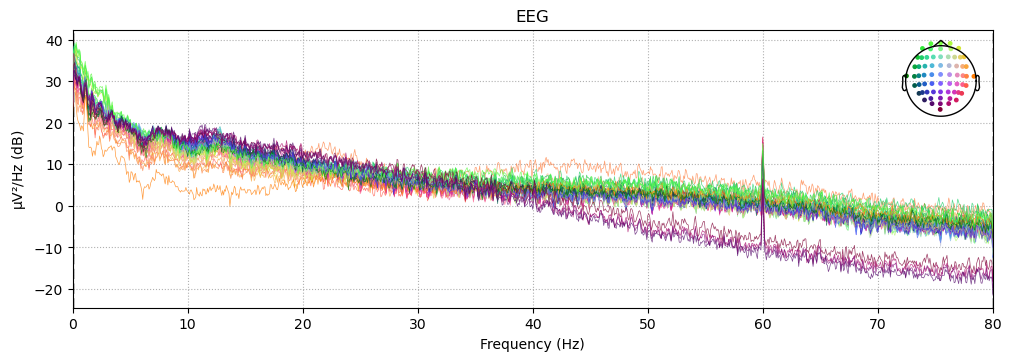

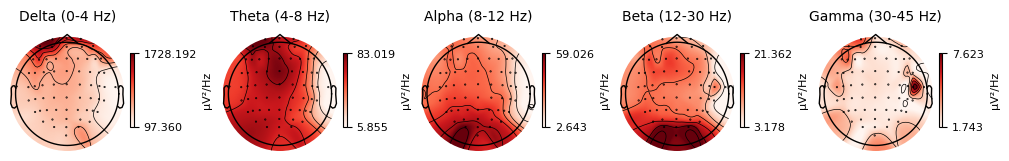

In [211]:
streams.compute_psd().plot();
streams.compute_psd().plot_topomap();

## Preprocessing

In [212]:
def preprocessing(raws_data, event, chans_selected:list):
    # --- Apply Re-reference by Common Average Reference (CAR) ---
    streams = raws_data.copy().set_eeg_reference('average', projection=True)
    
    # --- Filter Data ---
    stream_filter = streams.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    
    # --- Apply ICA ---
    ica = mne.preprocessing.ICA(n_components=63, random_state=97, max_iter=800)
    ica.fit(stream_filter.copy())
    
    # --- Find Bad Components ---
    bad_idx, scores = ica.find_bads_eog(stream_filter.copy(), ch_name='T9', threshold=1.5)
    
    # --- Remove Bad Components ---
    ica.exclude = bad_idx
    
    # --- Apply ICA to Filtered Data ---
    stream_ica = ica.apply(stream_filter.copy(),exclude=ica.exclude)
    
    # --- Events ---
    events, event_dict = mne.events_from_annotations(stream_filter)
    
    # --- Epoch ---
    epochs = mne.Epochs(stream_filter.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -0.5, tmax = 4, 
                    event_id = event, preload= True, verbose=False, event_repeated='drop')
    
    # --- Selected channels are interested ---
    if chans_selected != 'all':
        epochs = epochs.pick_channels(chans_selected, ordered = False)
    
    # --- Baseline Correction ---
    Baseline = epochs.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    stream_mi = Baseline.copy().apply_baseline((-0.5, 0))
    
    # --- reject bad channels ---
    def autoreject_epochs(epochs):
        reject = get_rejection_threshold(epochs)  
        reject.update(reject)
        epochs.drop_bad(reject = reject)
        return epochs
    stream_mi = autoreject_epochs(stream_mi.copy())
    
    return stream_mi

In [213]:
epochs = preprocessing(streams, event, chans_selected)
epochs

Estimating rejection dictionary for eeg


Number of events,45
Events,left: 23right: 22
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


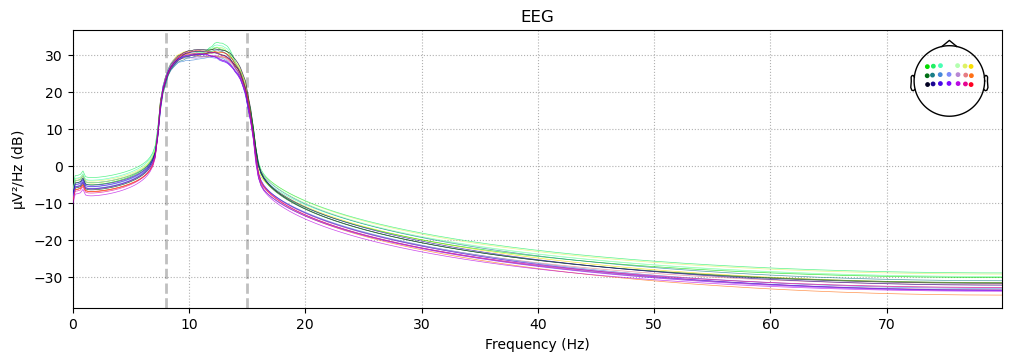

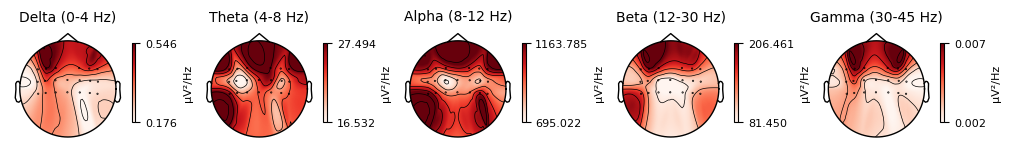

In [214]:
epochs.compute_psd().plot()
epochs.compute_psd().plot_topomap();

In [215]:
data = epochs.get_data(copy=True)

train_X = np.expand_dims(np.moveaxis(data, 0, 0), -1)
train_X.shape

(45, 20, 721, 1)

In [216]:
encoder = OneHotEncoder(sparse_output=False)

y = epochs.events[:, -1]
y = encoder.fit_transform(np.array(y).reshape(-1, 1))
y.shape

(45, 2)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.35, random_state=42)
print(f'Number of train set = {X_train.shape[0]}')
print(f'Number of  test set = {X_test.shape[0]}')

Number of train set = 29
Number of  test set = 16


# **Embedded Module**

In [394]:
class Classifier(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self):
        super(Classifier, self).__init__()
        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

         # Activation functions
        self.softmax = tf.keras.layers.Softmax()
        
        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        self.dense = tf.keras.layers.Dense(2, activation=None, kernel_regularizer=self.regularizer)

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.dense(feature))
        return y_hat

    def GAP(self, feature):
        return tf.reduce_mean(feature, -2)

    def call(self, feature):
        # Global Average Pooling
        feature = self.GAP(feature)

        # Decision making
        y_hat = self.classifier(feature)
        return y_hat

In [403]:
def gradient(model, inputs, labels, mask=None, csp=None):
    with tf.GradientTape() as tape:
        if mask is None:
            yhat = model(inputs)
        else:
            feature = model.GAP(np.transpose(np.array([csp.transform(inputs[:,:,:,0])]), (1,0,3,2)) * mask)
            yhat = model.classifier(feature)

        loss = tf.keras.losses.binary_crossentropy(labels, yhat)

    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

# **Agent Module**

In [220]:
class ACTOR(tf.keras.Model):
    def __init__(self, n_actions=2):
        super().__init__()
        self.actor = tf.keras.layers.Dense(n_actions, activation=None, 
                                          kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))        
    def call(self, segment):
        return self.actor(segment) # Outputs logit vector.
    
class CRITIC(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.critic = tf.keras.layers.Dense(1, activation=None,
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))
    def call(self, segment):
        return tf.keras.activations.sigmoid(self.critic(segment))

In [398]:
def agent_gradient(model, actor, critic, inputs, feature, labels, state, state_next):
    gamma = 0.95 # discount factor
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        loss_FM = tf.keras.losses.binary_crossentropy(labels, model(inputs))
        loss_AM = tf.keras.losses.binary_crossentropy(labels, model.classifier(feature))

        # Reward, r_t
        reward = loss_FM - loss_AM
        # Advantage, A_t
        advantage = reward[:, None] + gamma * critic(state_next) - critic(state)            
        # Critic loss
        critic_loss = 0.5 * tf.math.square(advantage)            
        # Actor loss
        actor_loss = -tf.math.log(tf.nn.softmax(actor(state))) * advantage

    critic_grad = tape1.gradient(critic_loss, critic.trainable_variables)
    # print("critic_grad: ", critic_grad)
    actor_grad = tape2.gradient(actor_loss, actor.trainable_variables)
    return critic_loss, critic_grad, actor_loss, actor_grad, reward

# **Experiments**

In [419]:
class experiment():
    def __init__(self, train_X, train_Y, test_X, test_Y):
        # Load dataset.
        self.Xtr, self.Ytr = train_X, train_Y
        self.Xts, self.Yts = test_X, test_Y
        self.Yts = np.argmax(self.Yts, axis=-1) # To use scikit-learn accuracy function
        
        # Randomize the training dataset.
        rand_idx = np.random.permutation(self.Xtr.shape[0])
        self.Xtr, self.Ytr = self.Xtr[rand_idx, :, :, :], self.Ytr[rand_idx, :]

        # Learning schedules
        self.init_LR = 1e-1
        self.num_epochs_pre = 20 # Pre-training epochs
        self.num_epochs = 30
        self.num_batch = 20
        self.optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=self.init_LR)
        
        # Call optimizer.
        self.num_batch_iter = int(self.Xtr.shape[0]/self.num_batch)
        
    def training_FM(self):
        print(f"Classification without agent module ------\n")

        # Call Dense Layer.
        classifier = Classifier()

        csp = CSP(n_components = 20, norm_trace = False, transform_into = 'csp_space')
        csp.fit(self.Xtr[:,:,:,0],np.argmax(self.Ytr, axis=-1))
        
        # To record the loss curve.
        loss_FM = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):                                  
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                features = np.transpose(np.array([csp.transform(xb[:,:,:,0])]), (1,0,3,2))

                # Estimate loss
                loss, grads = gradient(classifier, features, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, classifier.trainable_variables))
                loss_FM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Ytr_hat = np.argmax(classifier(np.transpose(np.array([csp.transform(self.Xtr[:,:,:,0])]), (1,0,3,2))), axis=-1)
        Yts_hat = np.argmax(classifier(np.transpose(np.array([csp.transform(self.Xts[:,:,:,0])]), (1,0,3,2))), axis=-1)
        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx},\
        print(f"\nTraining accuracy: {accuracy_score(np.argmax(self.Ytr, axis=-1), Ytr_hat)}!")
        print(f"Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_FM, csp, classifier
    
    def training_AM(self):
        print(f"Classification with agent module ---------\n")

        # Call Dense Layer..
        classifier = Classifier()

        csp = CSP(n_components = 20, norm_trace = False, transform_into = 'csp_space')
        csp.fit(self.Xtr[:,:,:,0],np.argmax(self.Ytr, axis=-1))
        
        # To record the loss curve.
        loss_AM = []
        # Pre-training without the agent module
        for epoch in range(self.num_epochs_pre):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                features = np.transpose(np.array([csp.transform(xb[:,:,:,0])]), (1,0,3,2))

                # Estimate loss
                loss, grads = gradient(classifier, features, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, classifier.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Call agent module.
        actor = ACTOR()
        critic = CRITIC()

        reward_history = []
        actor_loss_history = []
        critic_loss_history = []
        
        # Training with the agent module
        for epoch in range(self.num_epochs - self.num_epochs_pre):
            loss_per_epoch = 0
            
            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                features = np.transpose(np.array([csp.transform(xb[:,:,:,0])]), (1,0,3,2))
                
                agg_wo_current = np.zeros((self.num_batch, features.shape[-1]))
                num_added = np.zeros((self.num_batch, features.shape[-1])) # To estimate the denominator.
                mask = np.zeros(features.shape) # Mask generated by the agent module
                for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
                    # print('epoch :',epoch, 'batch :', batch, 't :', t)
                    deno1 = np.copy(num_added)
                    deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                    # To avoid zero-division.
                    deno1[deno1 == 0] = 1.
                    
                    agg_w_current = agg_wo_current + features[:, 0, t, :]
                    
                    # Define state, s_t.
                    state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                    # Get action, a_t.
                    action_probs = actor(state)
                    action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 20) 
                    mask[:, 0, t, :] = action
                    num_added += action
                    
                    # Current feature after action decision, phi_t.
                    deno3 = np.copy(num_added)
                    deno3[deno3 == 0] = 1 # To avoid zero-division.
                    feature = (agg_wo_current + features[:, 0, t, :] * action)/deno3
                    
                    # Define next state, s_{t+1}, temporally.
                    agg_wo_current = feature
                    tmp = agg_wo_current + features[:, 0, t + 1, :]
                    state_next = np.concatenate((agg_wo_current/deno3, tmp/(deno3 + 1)), axis=-1)

                    # Calculate critic and actor loss values
                    critic_loss, critic_grads, actor_loss, actor_grads, reward = agent_gradient(classifier, actor, critic, xb, feature, yb, state, state_next)
                    
                    reward_history.append(reward.numpy())
                    actor_loss_history.append(actor_loss.numpy())
                    critic_loss_history.append(critic_loss.numpy())
                    
                    self.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                    # print("critic :",critic.trainable_variables)
                    self.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
                                        
                # Finally, predict labels of input EEG using the selected segments.                
                # Update the parameters
                loss, grads = gradient(classifier, xb, yb, mask, csp)
                self.optimizer.apply_gradients(zip(grads, classifier.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)
                
            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1 + self.num_epochs_pre}, Training Loss {loss_per_epoch:>.04f}")
        
        acc = []
        for X, Y in [(self.Xtr, np.argmax(self.Ytr, axis=-1)),(self.Xts, self.Yts)]:
            Y_hat = np.argmax(classifier(np.transpose(np.array([csp.transform(X[:,:,:,0])]), (1,0,3,2))), axis=-1)
            acc.append(accuracy_score(Y, Y_hat))

        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx}, \
        print(f"\nTraining accuracy: {acc[0]}!")
        print(f"Testing accuracy: {acc[1]}!\n")
        return loss_AM, reward_history, actor_loss_history, critic_loss_history, actor, critic, csp, classifier

with tf.device('/gpu:1'):
    exp = experiment(X_train, y_train, X_test, y_test)
    loss_FM, csp_FM, classifier_FM = exp.training_FM()
    loss_AM, reward_history, actor_loss_history, critic_loss_history, actor, critic, csp_AM, classifier_AM = exp.training_AM()

Classification without agent module ------

Iteration 1, Training Loss 0.6836
Iteration 2, Training Loss 0.6903
Iteration 3, Training Loss 0.6185
Iteration 4, Training Loss 0.5988
Iteration 5, Training Loss 0.5826
Iteration 6, Training Loss 0.5684
Iteration 7, Training Loss 0.5558
Iteration 8, Training Loss 0.5443
Iteration 9, Training Loss 0.5337
Iteration 10, Training Loss 0.5238
Iteration 11, Training Loss 0.5146
Iteration 12, Training Loss 0.5058
Iteration 13, Training Loss 0.4975
Iteration 14, Training Loss 0.4896
Iteration 15, Training Loss 0.4820
Iteration 16, Training Loss 0.4747
Iteration 17, Training Loss 0.4677
Iteration 18, Training Loss 0.4609
Iteration 19, Training Loss 0.4543
Iteration 20, Training Loss 0.4479
Iteration 21, Training Loss 0.4417
Iteration 22, Training Loss 0.4357
Iteration 23, Training Loss 0.4298
Iteration 24, Training Loss 0.4240
Iteration 25, Training Loss 0.4184
Iteration 26, Training Loss 0.4129
Iteration 27, Training Loss 0.4076
Iteration 28, Traini

100%|██████████| 720/720 [00:45<00:00, 15.81it/s]


Iteration 21, Training Loss 0.3730


100%|██████████| 720/720 [00:42<00:00, 16.76it/s]


Iteration 22, Training Loss 0.2993


100%|██████████| 720/720 [00:43<00:00, 16.42it/s]


Iteration 23, Training Loss 0.2879


100%|██████████| 720/720 [00:45<00:00, 15.92it/s]


Iteration 24, Training Loss 0.2789


100%|██████████| 720/720 [00:43<00:00, 16.40it/s]


Iteration 25, Training Loss 0.2711


100%|██████████| 720/720 [00:44<00:00, 16.12it/s]


Iteration 26, Training Loss 0.2640


100%|██████████| 720/720 [00:43<00:00, 16.60it/s]


Iteration 27, Training Loss 0.2575


100%|██████████| 720/720 [00:48<00:00, 15.00it/s]


Iteration 28, Training Loss 0.2514


100%|██████████| 720/720 [00:42<00:00, 16.81it/s]


Iteration 29, Training Loss 0.2455


100%|██████████| 720/720 [00:41<00:00, 17.41it/s]


Iteration 30, Training Loss 0.2399


100%|██████████| 720/720 [00:07<00:00, 101.12it/s]


Training accuracy: 0.5517241379310345!
Testing accuracy: 0.5517241379310345!



In [ ]:
def mask_generate_csp(actor, csp, X):
    features = np.transpose(np.array([csp.transform(X[:,:,:,0])]), (1,0,3,2))
    agg_wo_current = np.zeros((X.shape[0], features.shape[-1]))
    num_added = np.zeros((X.shape[0], features.shape[-1])) # To estimate the denominator.
    mask = np.zeros(features.shape) # Mask generated by the agent module
    for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
        # print('epoch :',epoch, 'batch :', batch, 't :', t)
        deno1 = np.copy(num_added)
        deno2 = np.copy(num_added) + 1 # For the features with the current segment.
        # To avoid zero-division.
        deno1[deno1 == 0] = 1.
        
        agg_w_current = agg_wo_current + features[:, 0, t, :]
        
        # Define state, s_t.
        state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
        # Get action, a_t.
        action_probs = actor(state)
        action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 20)
        mask[:, 0, t, :] = action
        num_added += action
        
        # Current feature after action decision, phi_t.
        deno3 = np.copy(num_added)
        deno3[deno3 == 0] = 1 # To avoid zero-division.
        agg_wo_current = (agg_wo_current + features[:, 0, t, :] * action)/deno3
    return mask